# Import library

In [1]:
import random as rnd
import numpy as np
from math import *
import matplotlib.pyplot as plt
from scipy.signal import convolve2d

#1000 people, 500 event, 250 good and bad

# # world map of 50*50, world map is unnecessary
# wmap_size = 50
# world_map = np.full((wmap_size,wmap_size,2),[-1,-1])
# print(world_map)


# Fx: Gen random row ,col

In [2]:
def gen_rnd_pos( map_width, num_point): #return list of [row, col]
    indices = np.random.choice(map_width*map_width, num_point , replace=False)
    points = np.unravel_index(indices, (map_width, map_width))
    p_row, p_col = points
    row_col_lst = np.array(list(zip(p_row, p_col)))
    return row_col_lst

# Generate People (Instantiation)

## Generate Person

In [3]:
## Generate 1000 unique people position
NUM_PEOPLE = 1000
MAP_SIZE = 500
p_pos_lst = gen_rnd_pos(MAP_SIZE, NUM_PEOPLE)


## Generate People list

In [4]:
## Create people: list of person object, each person object: row, col, talent, wealth_history
class Person:
    def __init__(self, row, col, talent , capital, good_events_history, bad_events_history, wealth_history = [10] ):
        self.row = row
        self.col = col
        self.talent = talent
        self.capital = capital
        self.good_events_history = []
        self.bad_events_history = []
        self.wealth_history = wealth_history


people_list = []


## Talent and other attribute assign for Person

In [5]:
#Talent
talent_normal_lst = np.random.normal(0.5, 0.166, 1000)

for i in range(NUM_PEOPLE):
    if talent_normal_lst[i] < 0:
        talent_ = 0.01
    elif talent_normal_lst[i] > 1:
        talent_ = 1
    else:
       talent_ = talent_normal_lst[i]
    people_list.append(Person(p_pos_lst[i,0], p_pos_lst[i,1], talent_, 10 ,[], [], [10]))


# Create Direction Table reference

In [6]:
direction_ref = {
    1: [-2, -2],
    2: [-2, -1],
    3: [-2, 0],
    4: [-2, 1],
    5: [-2, 2],
    6: [-1, -2],
    7: [-1, -1],
    8: [-1, 0],
    9: [-1, 1],
    10: [-1, 2],
    11: [0, -2],
    12: [0, -1],
    13: [0, 0],
    14: [0, 1],
    15: [0, 2],
    16: [1, -2],
    17: [1, -1],
    18: [1, 0],
    19: [1, 1],
    20: [1, 2],
    21: [2, -2],
    22: [2, -1],
    23: [2, 0],
    24: [2, 1],
    25: [2, 2]
}

## Generate goodmap, good_posl, bad_map, bad_posl

In [7]:
# good map of 50*50, world map is unnecessary
NUM_GOOD = 250
NUM_BAD = 250

good_map = np.full((MAP_SIZE,MAP_SIZE), 0,dtype=int) #initialize
g_pos_lst = gen_rnd_pos(MAP_SIZE, NUM_GOOD)

# place good events into good map
for i in range(len(g_pos_lst)):
    good_map[g_pos_lst[i,0], g_pos_lst[i,1]] = 1

bad_map = np.full((MAP_SIZE,MAP_SIZE), 0) #initialize
b_pos_lst = gen_rnd_pos(MAP_SIZE, NUM_BAD)

# place events into good map
for i in range(len(g_pos_lst)):
    bad_map[b_pos_lst[i,0], b_pos_lst[i,1]] = 1

## Resolve index for toroidal

In [8]:
def resolve_index( width, before_index ):
    if before_index < 0:
        s = -before_index
        return width - s
    elif before_index > width-1:
        s = before_index - (width -1)
        return -1 + s
    else:
        return before_index

## Move Event function

In [9]:
# param:
def move( map, pos_list, map_size):
    for i in range(len(pos_list)):
        move_choice = rnd.randint(1,25)

        #debug
#         print(f'move_choice: {move_choice}')
        map[pos_list[i][0], pos_list[i][1]] -= 1
        pos_list[i][0] = resolve_index(MAP_SIZE, pos_list[i][0] + direction_ref[move_choice][0] )
        pos_list[i][1] = resolve_index(MAP_SIZE, pos_list[i][1] + direction_ref[move_choice][1] )
        map[pos_list[i][0], pos_list[i][1]] += 1
#         print(map)

# #debug
# pos_list1 = [[1,2], [2,5], [3,6], [6,5]]

# map1 = np.full((7,7),0)
# for i in range(len(pos_list1)):
#     map1[pos_list1[i][0],pos_list1[i][1]] = 1

# move(map1, pos_list1,7)
# print(map1)

# Fx: Capital update

In [10]:
def capital_update( good_num_map, bad_num_map):
    for i in range(len(people_list)):
        good_num = good_num_map[people_list[i].row][ people_list[i].col]
        bad_num = bad_num_map[people_list[i].row] [people_list[i].col]

        people_list[i].good_events_history.append(good_num)
        people_list[i].bad_events_history.append(-1*bad_num)

        for j in range(good_num):
            u = rnd.uniform(0,1)

            #debug
            #print(f'u:{type(u)},peoplelst[i]:{people_list[i]}, talent:{type(people_list[i].talent)}')

            people_list[i].capital = people_list[i].capital * 2 if u <= people_list[i].talent else people_list[i].capital
        for k in range(bad_num):
            u = rnd.uniform(0,1)
          #try
            people_list[i].capital *= 0.5
            #people_list[i].capital = people_list[i].capital * 0.6 if u >= people_list[i].talent else people_list[i].capital


        people_list[i].wealth_history.append(people_list[i].capital)

## Check event function: and update


In [11]:
def check_events(good_map, bad_map, people_list):
    # Padding good_map and bad_map with zeros
    padded_good_map = np.pad(good_map, 1, mode='constant')
    padded_bad_map = np.pad(bad_map, 1, mode='constant')

    good_num_map = np.zeros_like(good_map)
    bad_num_map = np.zeros_like(bad_map)

    for person in people_list:
        row, col = person.row, person.col

        # Calculate the sum within the 3x3 kernel around the person's coordinates for good_map
        kernel_sum_good = np.sum(padded_good_map[row:row + 3, col:col + 3])

        # Save the sum to the center grid's coordinate in good_num_map
        good_num_map[row, col] = kernel_sum_good

        # Calculate the sum within the 3x3 kernel around the person's coordinates for bad_map
        kernel_sum_bad = np.sum(padded_bad_map[row:row + 3, col:col + 3])

        # Save the sum to the center grid's coordinate in bad_num_map
        bad_num_map[row, col] = kernel_sum_bad

    # Call capital_update with good_num_map and bad_num_map
    capital_update(good_num_map, bad_num_map)

#     return good_num_map, bad_num_map
# def check_events(good_map, bad_map): #deal with both good and bad map
#     # pad zero
#     pad_good_array = np.pad( good_map , ((1, 1), (1, 1)), mode='constant', constant_values=0)
#     pad_bad_array = np.pad( bad_map , ((1, 1), (1, 1)), mode='constant', constant_values=0)

#     # 创建一个3x3全为1的核心
#     kernel = np.ones((3, 3), dtype = np.int32)

#     # 执行二维卷积操作
#     good_num_map = convolve2d(pad_good_array, kernel, mode='valid')
#     bad_num_map = convolve2d(pad_bad_array, kernel, mode='valid')

#     # #debug
#     # print(f'good_map:{good_map}')
#     # print(f'bad_map:{bad_map}')
#     # print(f'good_num_map:{good_num_map}')
#     # print(f'good_num_map:{bad_num_map}')
#     capital_update(good_num_map, bad_num_map)

# Main()

In [12]:
# Metaview: simulation process
# Generate people
# Generate good bad map
for i in range( 80 ):
    move(good_map, g_pos_lst, MAP_SIZE)
    move(bad_map, b_pos_lst, MAP_SIZE)
    check_events(good_map, bad_map, people_list)

# 80 times:
    # move once
    # check once

# Analyze

In [13]:
# Find richest
capital_list = []
for i in range(len(people_list)):
    capital_list.append(people_list[i].capital)
# print(capital_list)
# print(len(people_list))
# print(np.argmin(capital_list))
# print(people_list[np.argmin(capital_list)].wealth_history)

## Talent Distribution

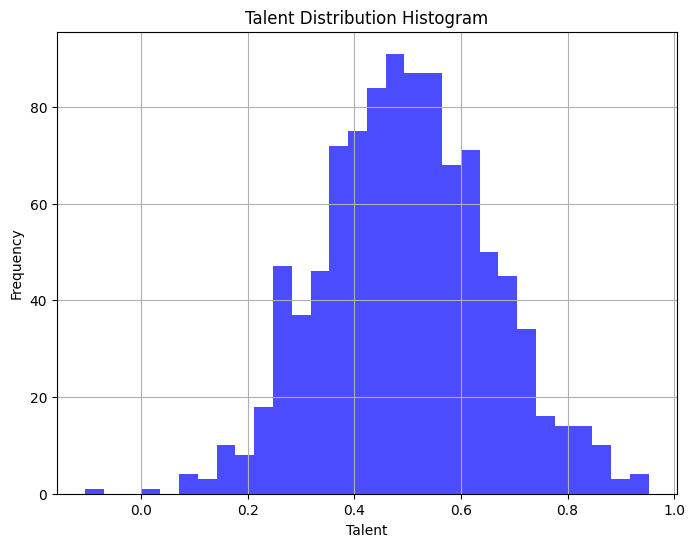

In [14]:
import matplotlib.pyplot as plt

# Assuming you have the talent list named talent_normal_lst

# Plotting the histogram
plt.figure(figsize=(8, 6))
plt.hist(talent_normal_lst, bins=30, alpha=0.7, color='blue')

plt.title('Talent Distribution Histogram')
plt.xlabel('Talent')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

##World_Map Visulization

Text(0, 0.5, 'Row')

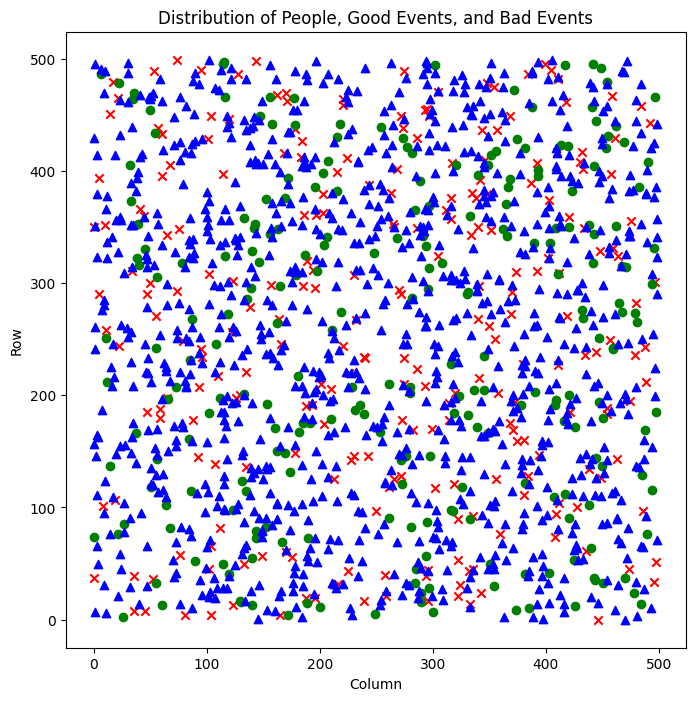

In [15]:
# Create a figure and axis
fig, ax = plt.subplots(figsize=(8, 8))

# Plotting the bad events
for b_pos in b_pos_lst:
    ax.scatter(b_pos[1], b_pos[0], color='red', marker='x', label='Bad Events')

# Plotting the good events
for g_pos in g_pos_lst:
    ax.scatter(g_pos[1], g_pos[0], color='green', marker='o', label='Good Events')

# Plotting the people
for p_pos in p_pos_lst:
    ax.scatter(p_pos[1], p_pos[0], color='blue', marker='^', label='People')

# Set plot title and labels
ax.set_title('Distribution of People, Good Events, and Bad Events')
ax.set_xlabel('Column')
ax.set_ylabel('Row')

##Number of individuals vs capital

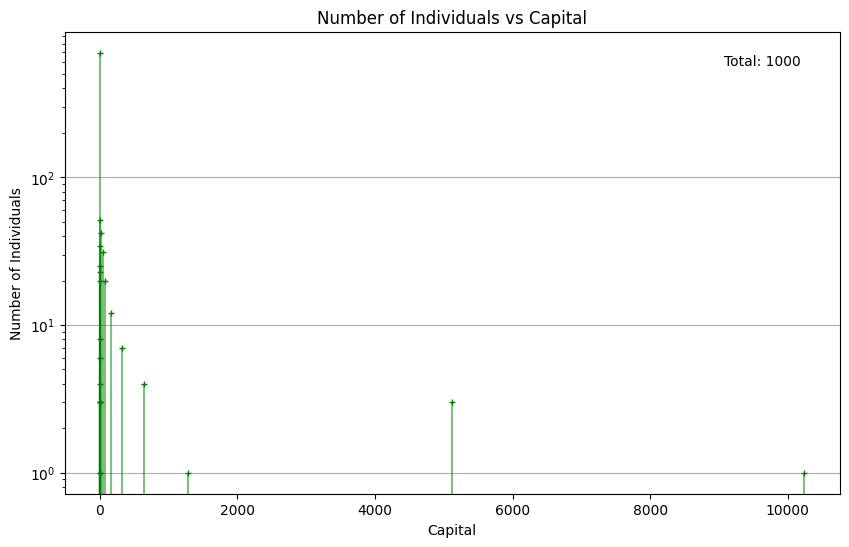

In [16]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming you have the people_list containing Person objects with their respective capital values

# Extracting the capitals from the people_list
capital_list = [person.capital for person in people_list]

# Creating a dictionary to count individuals for each capital value
capital_counts = {}
for capital in capital_list:
    if capital in capital_counts:
        capital_counts[capital] += 1
    else:
        capital_counts[capital] = 1

# Getting unique capital values and their counts
unique_capitals, counts = zip(*sorted(capital_counts.items()))

# Plotting the Number of individuals vs Capital with '+' markers and lines
plt.figure(figsize=(10, 6))
plt.plot(unique_capitals, counts, '+', color='green', markersize=4)

# Plotting lines under each data point
for i, (capital, count) in enumerate(zip(unique_capitals, counts)):
    plt.vlines(capital, ymin=0, ymax=count, color='green', linestyle='-', alpha=0.5)

plt.title('Number of Individuals vs Capital')
plt.xlabel('Capital')
plt.ylabel('Number of Individuals')
plt.grid(axis='y')

plt.yscale('log')  # Set y-axis to logarithmic scale

# Display the total count
plt.text(0.95, 0.95, f'Total: {sum(counts)}', ha='right', va='top', transform=plt.gca().transAxes)

plt.show()


##80/20 rule?

In [17]:
capital_list = [person.capital for person in people_list]
sorted_capital = sorted(capital_list)


print(f'Ratio of capital of top 20% to whole capital:{sum(sorted_capital[-1:-(NUM_PEOPLE // 5)-1:-1]) / sum(sorted_capital)}') # Use // for integer division
print(f'capital of top 20%:{sum(sorted_capital[-1:-(NUM_PEOPLE // 5)-1:-1])}' )
#print(f'capital of last 80%:{sum(sorted_capital[0:NUM_PEOPLE * 4 // 5])}')
print(f'capital of total population:{sum(sorted_capital)}')


Ratio of capital of top 20% to whole capital:0.8527670543779392
capital of top 20%:38070.0
capital of total population:44642.906646728516


##LOG Number of individuals vs LOG capital

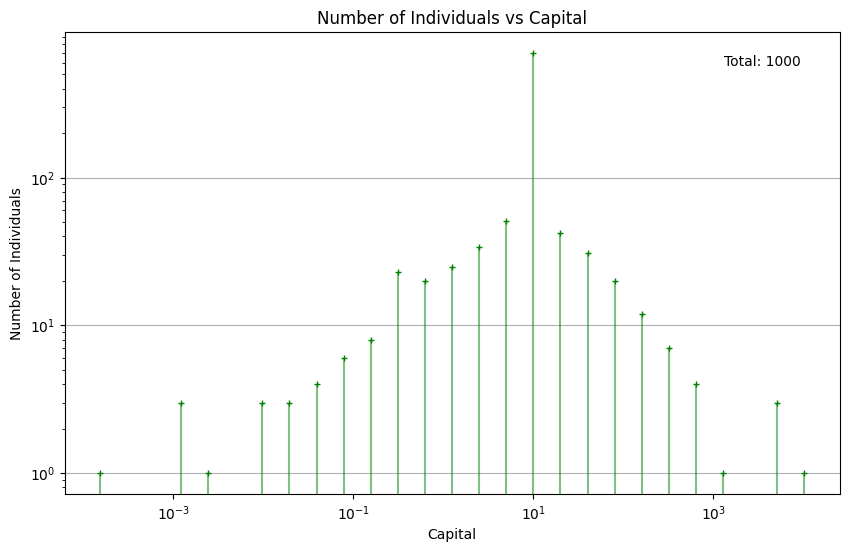

In [18]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming you have the people_list containing Person objects with their respective capital values

# Extracting the capitals from the people_list
capital_list = [person.capital for person in people_list]

# Creating a dictionary to count individuals for each capital value
capital_counts = {}
for capital in capital_list:
    if capital in capital_counts:
        capital_counts[capital] += 1
    else:
        capital_counts[capital] = 1

# Getting unique capital values and their counts
unique_capitals, counts = zip(*sorted(capital_counts.items()))

# Plotting the Number of individuals vs Capital with '+' markers and lines
plt.figure(figsize=(10, 6))
plt.plot(unique_capitals, counts, '+', color='green', markersize=4)

# Plotting lines under each data point
for i, (capital, count) in enumerate(zip(unique_capitals, counts)):
    plt.vlines(capital, ymin=0, ymax=count, color='green', linestyle='-', alpha=0.5)

plt.title('Number of Individuals vs Capital')
plt.xlabel('Capital')
plt.ylabel('Number of Individuals')
plt.grid(axis='y')

plt.xscale('log')
plt.yscale('log')  # Set y-axis to logarithmic scale

# Display the total count
plt.text(0.95, 0.95, f'Total: {sum(counts)}', ha='right', va='top', transform=plt.gca().transAxes)

plt.show()


##Capital vs talent

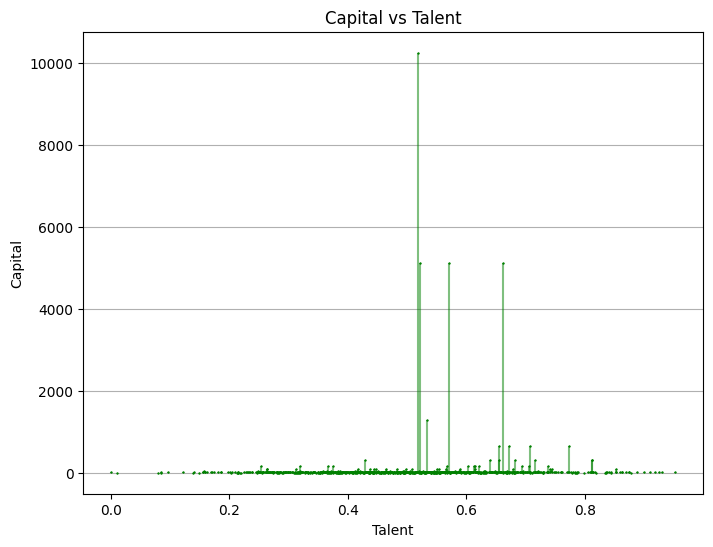

In [19]:
import matplotlib.pyplot as plt

# Assuming you have the people_list containing Person objects with talent and capital attributes

# Extracting talent and capital values from the people_list
talent_values = [person.talent for person in people_list]
capital_values = [person.capital for person in people_list]

# Plotting Capital vs Talent with lines under circles
plt.figure(figsize=(8, 6))
plt.plot(talent_values, capital_values, '+', color='green', markersize=2)  # Circles

# Plotting lines under the circles for emphasis
for talent, capital in zip(talent_values, capital_values):
    plt.vlines(talent, ymin=0, ymax=capital, color='green', linestyle='-', alpha=0.5)  # Lines under circles

plt.title('Capital vs Talent')
plt.xlabel('Talent')
plt.ylabel('Capital')
plt.grid(axis='y')

plt.show()


##Talent vs capital


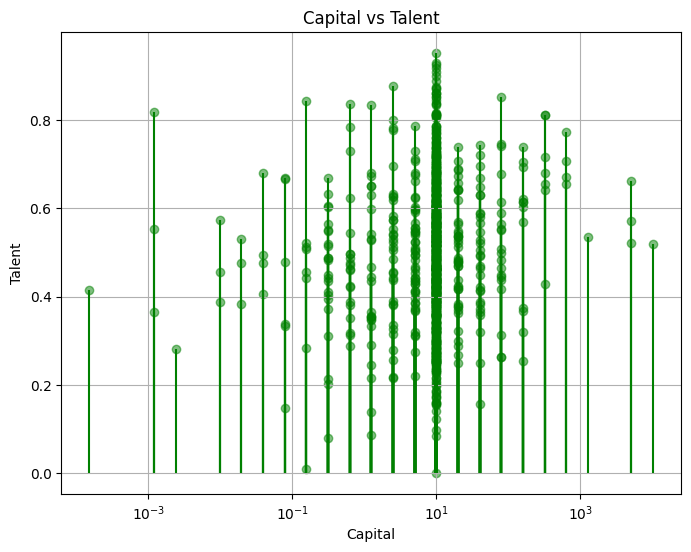

In [20]:
# import matplotlib.pyplot as plt

# # Assuming talent_values and capital_values contain the corresponding data from your people_list

# # Scatter plot of Capital vs Talent with a logarithmic x-axis
# plt.figure(figsize=(8, 6))
# plt.scatter(capital_values, talent_values, alpha=0.5, color='green')
# plt.title('Capital vs Talent')
# plt.xlabel('Capital')
# plt.ylabel('Talent')
# plt.xscale('log')  # Set x-axis to logarithmic scale
# plt.grid(True)
# plt.show()
import matplotlib.pyplot as plt
import numpy as np

# Assuming talent_values and capital_values contain the corresponding data from your people_list

# Scatter plot of Capital vs Talent with a logarithmic x-axis
plt.figure(figsize=(8, 6))
plt.scatter(capital_values, talent_values, alpha=0.5, color='green')
plt.title('Capital vs Talent')
plt.xlabel('Capital')
plt.ylabel('Talent')
plt.xscale('log')  # Set x-axis to logarithmic scale

# Add lines under each dot
plt.vlines(capital_values, ymin = 0 , ymax= [y for y in talent_values], color='green')

plt.grid(True)
plt.show()



##Number of lucky events vs capital

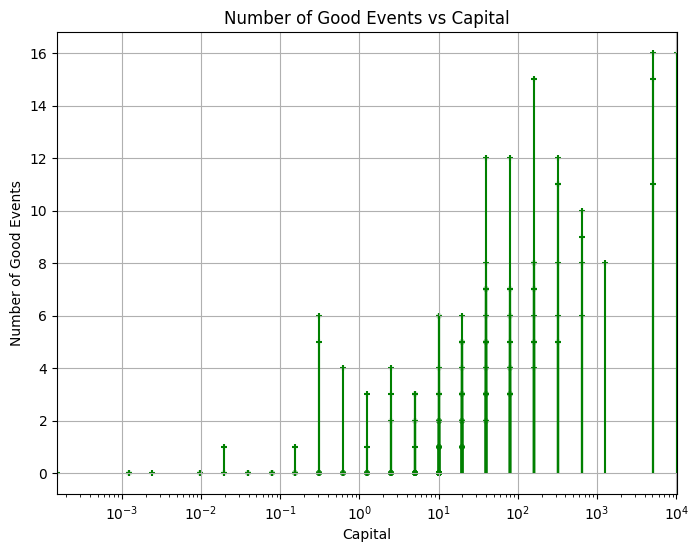

In [21]:
# Calculate the sum of good events for each person
good_event_counts = [sum(person.good_events_history) for person in people_list]

# Extract capital values for each person
capital_values = [person.capital for person in people_list]

# Plotting the Number of Good Events vs. Capital
plt.figure(figsize=(8, 6))
plt.scatter(capital_values, good_event_counts,marker = '+', color='green', s = 15)
# Add lines under each dot
plt.vlines(capital_values, ymin = 0 , ymax= good_event_counts, color='green')
plt.title('Number of Good Events vs Capital')
plt.xlabel('Capital')
plt.ylabel('Number of Good Events')
plt.grid(True)
plt.xscale('log')
# Adjusting x-axis limits to ensure all data points are visible
plt.xlim(min(capital_values), max(capital_values))

plt.show()

##Number of Bad events vs capital

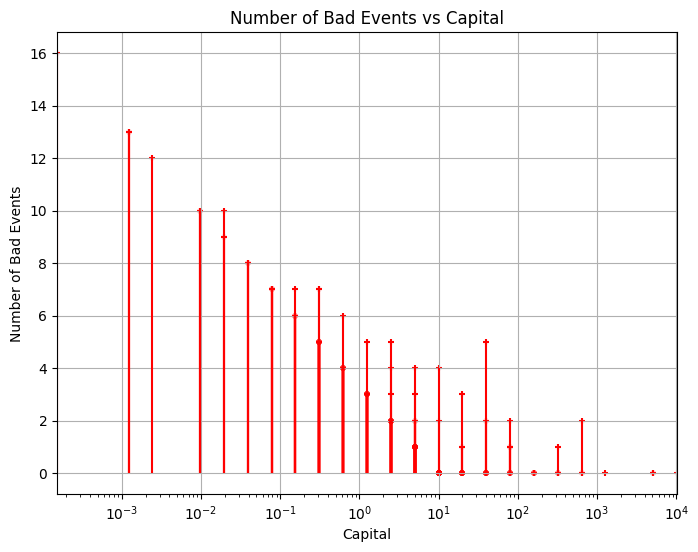

In [22]:
# Calculate the sum of good events for each person
bad_event_counts = [sum(person.bad_events_history) for person in people_list]
# Plotting the Number of Good Events vs. Capital
plt.figure(figsize=(8, 6))
plt.scatter(capital_values, np.abs(bad_event_counts),marker = '+', color='red', s = 15)
# Add lines under each dot
plt.vlines(capital_values, ymin = 0 , ymax= np.abs(bad_event_counts), color='red')
plt.title('Number of Bad Events vs Capital')
plt.xlabel('Capital')
plt.ylabel('Number of Bad Events')
plt.grid(True)
plt.xscale('log')
# Adjusting x-axis limits to ensure all data points are visible
plt.xlim(min(capital_values), max(capital_values))

plt.show()

##Number of agents vs good_events

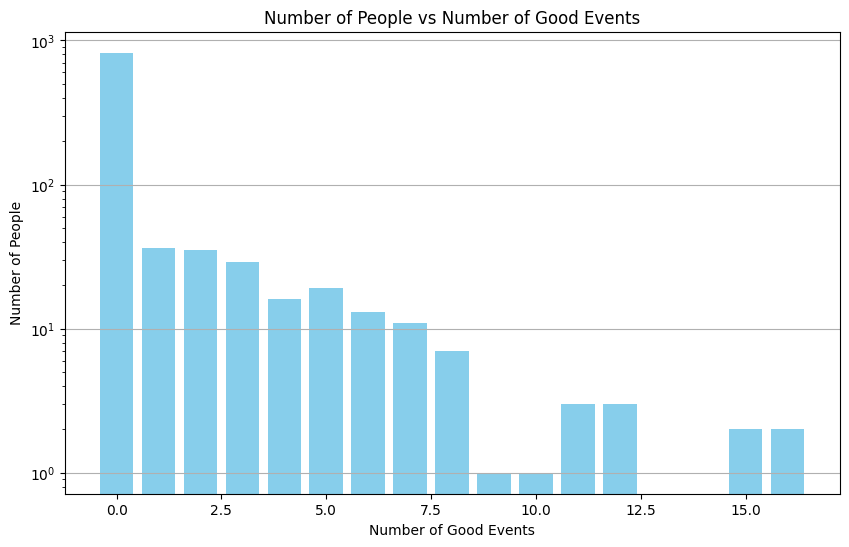

In [23]:
from collections import Counter

# Extract the total number of good events for each person
total_good_events = [sum(person.good_events_history) for person in people_list]

# Count the occurrences of each number of good events
good_event_counter = Counter(total_good_events)

# Sort the counts by the number of good events
sorted_counts = sorted(good_event_counter.items())

# Separate the counts into x and y values for plotting
x_values = [count for count, freq in sorted_counts]
y_values = [freq for count, freq in sorted_counts]

# Plotting Number of People vs. Number of Good Events
plt.figure(figsize=(10, 6))
plt.bar(x_values, y_values, color='skyblue')
plt.title('Number of People vs Number of Good Events')
plt.xlabel('Number of Good Events')
plt.ylabel('Number of People')
plt.grid(axis='y')
plt.yscale('log')
plt.show()


##Number of agents vs bad_events

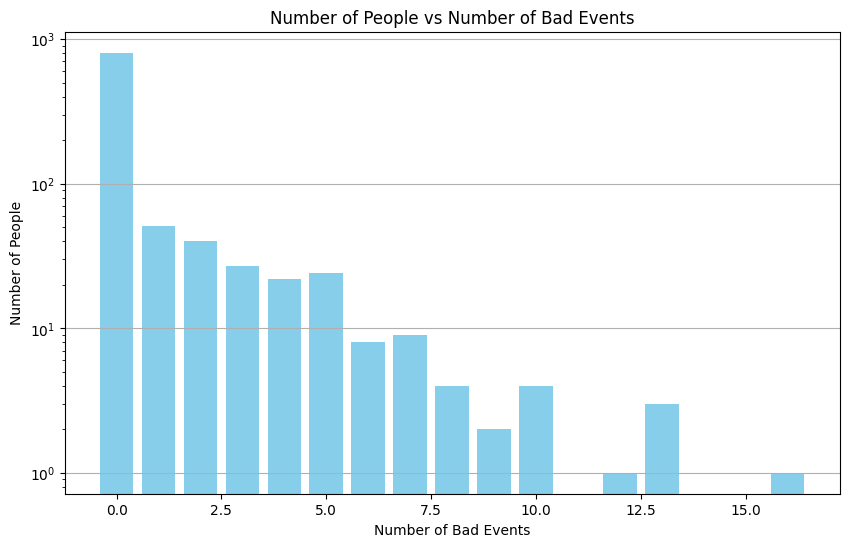

In [24]:
from collections import Counter

# Extract the total number of good events for each person
total_bad_events = [-sum(person.bad_events_history) for person in people_list]

# Count the occurrences of each number of good events
bad_event_counter = Counter(total_bad_events)

# Sort the counts by the number of good events
sorted_counts = sorted(bad_event_counter.items())

# Separate the counts into x and y values for plotting
x_values = [count for count, freq in sorted_counts]
y_values = [freq for count, freq in sorted_counts]

# Plotting Number of People vs. Number of Good Events
plt.figure(figsize=(10, 6))
plt.bar(x_values, y_values, color='skyblue')
plt.title('Number of People vs Number of Bad Events')
plt.xlabel('Number of Bad Events')
plt.ylabel('Number of People')
plt.grid(axis='y')
plt.yscale('log')
plt.show()

##Most successful lifetime capital vs time

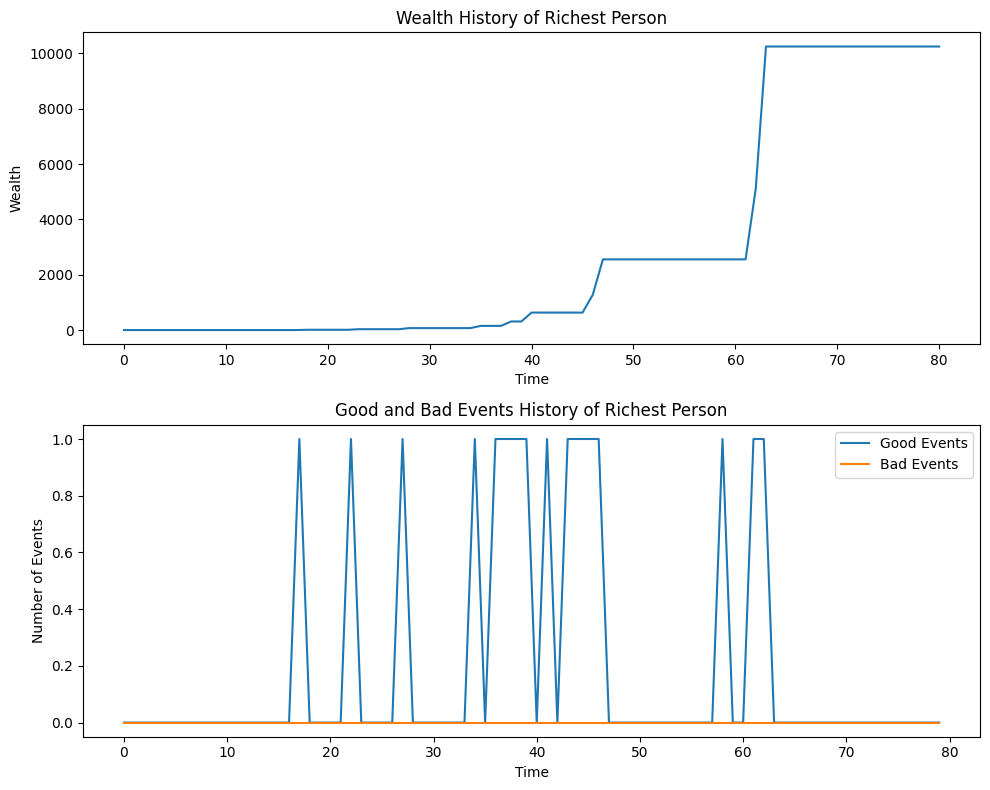

In [25]:
# Richest person index
richest_index = np.argmax(capital_values)

# Creating two subplots for 'a' and 'bc'
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

# Plot for 'a' (wealth history)
ax1.plot(range(81), people_list[richest_index].wealth_history)
ax1.set_title('Wealth History of Richest Person')
ax1.set_xlabel('Time')
ax1.set_ylabel('Wealth')

# Plot for 'bc' (good and bad events history)
ax2.plot(range(80), people_list[richest_index].good_events_history, label='Good Events')
ax2.plot(range(80), people_list[richest_index].bad_events_history, label='Bad Events')
ax2.set_title('Good and Bad Events History of Richest Person')
ax2.set_xlabel('Time')
ax2.set_ylabel('Number of Events')
ax2.legend()

plt.tight_layout()
plt.show()

##Less successful lifetime capital vs time

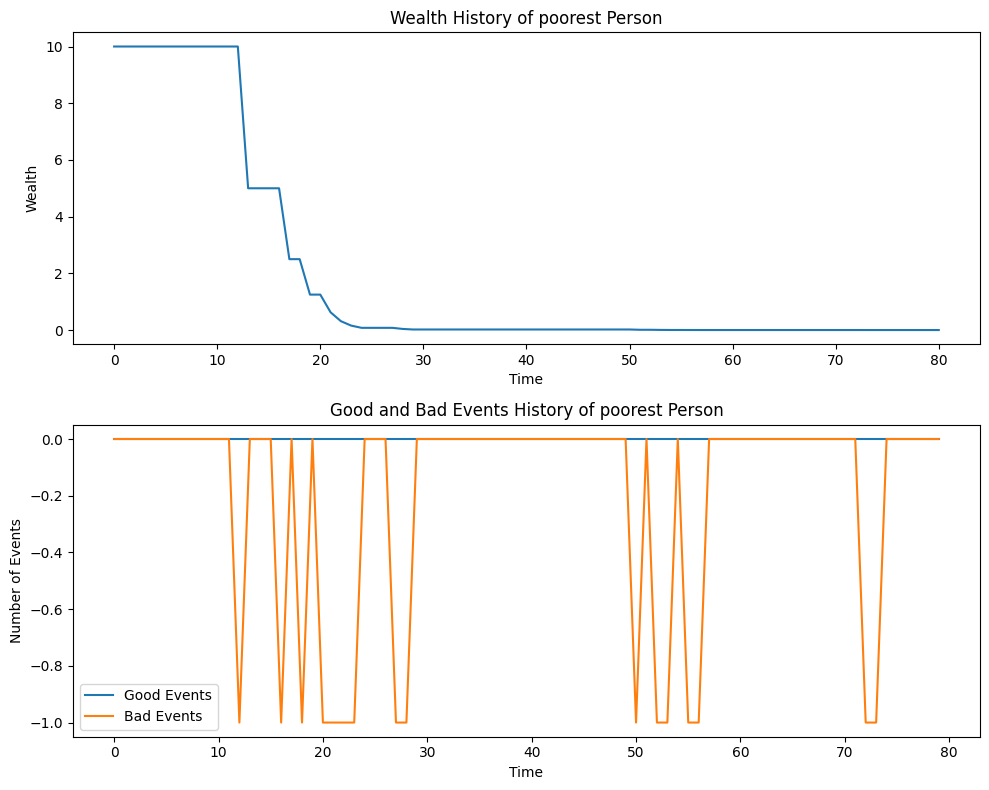

In [26]:
# Richest person index
poorest_index = np.argmin(capital_values)

# Creating two subplots for 'a' and 'bc'
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

# Plot for 'a' (wealth history)
ax1.plot(range(81), people_list[poorest_index].wealth_history)
ax1.set_title('Wealth History of poorest Person')
ax1.set_xlabel('Time')
ax1.set_ylabel('Wealth')

# Plot for 'bc' (good and bad events history)
ax2.plot(range(80), people_list[poorest_index].good_events_history, label='Good Events')
ax2.plot(range(80), people_list[poorest_index].bad_events_history, label='Bad Events')
ax2.set_title('Good and Bad Events History of poorest Person')
ax2.set_xlabel('Time')
ax2.set_ylabel('Number of Events')
ax2.legend()

plt.tight_layout()
plt.show()

# Self Note

In [27]:


## Assign normal distributed talent to each person in the people list


#Process: Need 2d world map(for person) (2d array 50*50, list of list, first all )
# Need 2d world map(for person) (2d array 50*50): sublist:[talent, wealth(list,for plot)], for space(non-person): [-1,-1]
# How : create rnd 0~49 for row,col, shuffle, then zip them as a list of list, called person_index_list
# Now we'll have

# Create pos_list for good and bad events: good_pos_list, bad_pos_list
# Create good_map (good_record) (50*50 and then zero padding): stores the number of good events on each grid( the distribution, may have 2 events on one grid)
# Create bad_map (bad_record): stores the number of good events on each grid( the distribution, may have 2 events on one grid)
# Need zero padding for above two maps

# Check the intersection of person and events: use scipy.convolve2d ( Can Optimize: eliminate redundant convolution)
# Need zero padding for good_map, bad_map


# Move the events around + Toroidal (Need function)


In [28]:
# import numpy as np

# # Define the check_events function
# def check_events(good_map, bad_map, people_list):
#     # Padding good_map and bad_map with zeros
#     padded_good_map = np.pad(good_map, 1, mode='constant')
#     padded_bad_map = np.pad(bad_map, 1, mode='constant')

#     good_num_map = np.zeros_like(good_map)
#     bad_num_map = np.zeros_like(bad_map)

#     for person in people_list:
#         row, col = person.row, person.col

#         # Calculate the sum within the 3x3 kernel around the person's coordinates for good_map
#         kernel_sum_good = np.sum(padded_good_map[row:row + 3, col:col + 3])

#         # Save the sum to the center grid's coordinate in good_num_map
#         good_num_map[row, col] = kernel_sum_good

#         # Calculate the sum within the 3x3 kernel around the person's coordinates for bad_map
#         kernel_sum_bad = np.sum(padded_bad_map[row:row + 3, col:col + 3])

#         # Save the sum to the center grid's coordinate in bad_num_map
#         bad_num_map[row, col] = kernel_sum_bad

#     # Call capital_update with good_num_map and bad_num_map
#     capital_update(good_num_map, bad_num_map)

#     return good_num_map, bad_num_map

# # Generating test data
# good_map = np.random.randint(0, 2, size=(5, 5))  # Generating a random 5x5 good_map (assuming binary values)
# bad_map = np.random.randint(0, 2, size=(5, 5))  # Generating a random 5x5 bad_map (assuming binary values)

# # Generating a sample people_list with Person objects having row, col attributes
# class Person:
#   def __init__(self, row, col):
#     self.row = row
#     self.col = col

# # Creating a sample people_list
# people_list = [Person(1, 1), Person(3, 2), Person(0, 4)]  # Add more sample Person objects as needed

# # Calling the check_events function with the generated test data
# good_num_map, bad_num_map = check_events(good_map, bad_map, people_list)

# # Printing the arrays
# print("Original Good Map:")
# print(good_map)
# print("\nResultant Good Number Map:")
# print(good_num_map)

# print("\nOriginal Bad Map:")
# print(bad_map)
# print("\nResultant Bad Number Map:")
# print(bad_num_map)
